In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [2]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pypinyin import lazy_pinyin

# Step 1: Change the working directory (update the path accordingly)
new_dir = "C:/Users/Andy/Documents/stock/"
os.chdir(new_dir)


C:\Users\Andy\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
df = pd.read_csv("Trim_train/merged_cleaned_data.csv")

In [68]:
df.columns

Index(['ID', 'wai', 'wai', 'wai', 'wai', 'wai', 'wai', 'wai', 'wai', 'wai',
       ...
       'shang', 'shang', 'shang', 'shang', 'shang', 'shang', 'shang', 'shang',
       'shang', 'biao'],
      dtype='object', length=673)

In [4]:
from pypinyin import lazy_pinyin
df.columns = [lazy_pinyin(col)[0] for col in df.columns]

In [5]:
target_column = "biao" 

In [396]:
X = df.drop(columns=[target_column, "ID"], errors="ignore")
y = df[target_column]

In [397]:
X.columns = [f"{col}_{i}" if X.columns.duplicated()[i] else col for i, col in enumerate(X.columns)]

In [398]:
X = X.fillna(X.mean())

In [399]:
X.columns

Index(['wai', 'wai_1', 'wai_2', 'wai_3', 'wai_4', 'wai_5', 'wai_6', 'wai_7',
       'wai_8', 'wai_9',
       ...
       'shang_661', 'shang_662', 'shang_663', 'shang_664', 'shang_665',
       'shang_666', 'shang_667', 'shang_668', 'shang_669', 'shang_670'],
      dtype='object', length=671)

In [264]:
# Calculate IQR for all numerical features
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define outliers: Any value outside 1.5 * IQR bounds
outlier_mask = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Create an "outlier count" column (number of outlier features per row)
X["outlier_count"] = outlier_mask.sum(axis=1)

# Optional: Convert to binary flag (1 if any outlier, 0 if none)
X["is_outlier"] = (X["outlier_count"] > 0).astype(int)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X["outlier_count_scaled"] = scaler.fit_transform(X[["outlier_count"]])

In [267]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [249]:
arguments = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "num_leaves": 20,
    "learning_rate": 0.01034,
    "n_estimators": 30000,
    "max_bin": 113,
    "subsample": 0.7708753433144212,
    "subsample_freq": 5,
    "colsample_bytree": 0.6628,
    "feature_fraction_seed": 42,
    "bagging_seed": 42,
    "min_child_samples": 25
}

In [252]:
BestHyperparameters = {'boosting_type': 'dart', 
                        'num_leaves': 10, 
                        'learning_rate': 0.004889109596845264, 
                        'n_estimators': 16943, 'max_bin': 232, 
                        'subsample': 0.7823086040575833, 'subsample_freq': 13, 
                        'colsample_bytree': 0.8106243879716812, 
                        'min_child_samples': 5}

In [270]:
Best_Hyperparameters_2 = {'num_leaves': 30, 
                       "boosting_type": "gbdt",
                        'learning_rate': 0.04775679749328264, 
                       'n_estimators': 14029, 
                       'max_bin': 111, 
                       'subsample': 0.9773059458207831, 
                       'subsample_freq': 1, 
                       'colsample_bytree': 0.9523986724033833, 
                       'min_child_samples': 30}

In [512]:
Best_Hyperparameters_3 = {'num_leaves': 45, 'learning_rate': 0.010556170455516557, 
                          'n_estimators': 44226, 'max_bin': 162,
                          'subsample': 0.8812363685123362, 'subsample_freq': 2,
                          'colsample_bytree': 0.545954397887439, 'min_child_samples': 31}

In [390]:
X_train.shape

(160691, 674)

In [253]:
# Count missing values per column
missing_values = X.isna().sum()

# Print only columns with missing values
missing_values = missing_values[missing_values > 0]
print(missing_values)

Series([], dtype: int64)


In [179]:
bigModel = lgb.LGBMClassifier(**arguments)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [438]:
bigModel = lgb.LGBMClassifier(**BestHyperparameters)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [513]:
bigModel = lgb.LGBMClassifier(**Best_Hyperparameters_3)
bigModel.fit(X_train, y_train)

# Step 6: Predict and Evaluate Accuracy
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [473]:
y_pred_proba = bigModel.predict_proba(X_test)[:, 1]  # Get probability for class 1

In [22]:
bigModel_2 = lgb.LGBMClassifier(class_weight="balanced",**arguments)
bigModel_2.fit(X_train, y_train)


In [389]:
X_train.shape

(160691, 674)

In [14]:
y_pred.shape

(40173,)

In [342]:
y_pred = (y_pred_proba >= 0.003).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.943662
Recall: 0.683673
F1 Score: 0.7929


In [446]:
y_pred = (y_pred_proba >= 0.25).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.943299
Recall: 0.622449
F1 Score: 0.7500


In [514]:
# including outlier index
y_pred = (y_pred_proba >= 0.0001).astype(int) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.722397
Recall: 0.778912
F1 Score: 0.7496


## Feature importance

In [49]:
X_train.columns = X_train.columns.astype(str)
X_test.columns =X_test.columns.astype(str)

# Rename duplicate columns by adding a suffix (_1, _2, etc.)
X_train.columns = pd.Series(X_train.columns).astype(str) + "_" + pd.Series(X_train.columns).groupby(X_train.columns).cumcount().astype(str)
X_test.columns = pd.Series(X_test.columns).astype(str) + "_" + pd.Series(X_test.columns).groupby(X_test.columns).cumcount().astype(str)


In [343]:
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": bigModel.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

# Keep only top 200 most important features
top_features = feature_importance.head(80)["feature"].tolist()

In [324]:
top_features

['ji_384',
 'shang_664',
 'ji_408',
 'shang_649',
 'shang_660',
 'shang_669',
 'shang_646',
 'ji_375',
 'ji_396',
 'ji_371',
 'shang_624',
 'ji',
 'shang_639',
 'shang_643',
 'shang_670',
 'ji_360',
 'shang_668',
 'shang_637',
 'shang_650',
 'ji_351',
 'shang_662',
 'shang_659',
 'shang_652',
 'shang_647',
 'ge_590',
 'shang_644',
 'shang_625',
 'shang_640',
 'shang_667',
 'ji_391',
 'shang_642',
 'shang_634',
 'ge_591',
 'shang_653',
 'shang_663',
 'shang_651',
 'ge_589',
 'shang_666',
 'shang_655',
 'shang_641',
 'shang_631',
 'ji_389',
 'ji_380',
 'shang_630',
 'ji_395',
 'ji_392',
 'shang_665',
 'shang_648',
 'shang_654',
 'ji_377',
 'shang_617',
 'ji_369',
 'shang_656',
 'ji_368',
 'shang',
 'ji_358',
 'ji_372',
 'shang_657',
 'shang_658',
 'ji_374',
 'outlier_count',
 'ji_376',
 'shang_638',
 'shang_620',
 'guan_177',
 'shang_618',
 'shang_635',
 'ji_398',
 'ji_388',
 'shang_627',
 'ji_385',
 'shang_645',
 'ji_383',
 'shang_621',
 'shang_661',
 'ji_409',
 'shang_623',
 'ji_428',


In [327]:
feature_importance[feature_importance['feature']=="outlier_count"]

,feature,importance
671,outlier_count,537


In [344]:
X_train_trimmed = X_train[top_features]
X_test_trimmed = X_test[top_features]

In [329]:
X_train.columns

Index(['wai', 'wai_1', 'wai_2', 'wai_3', 'wai_4', 'wai_5', 'wai_6', 'wai_7',
       'wai_8', 'wai_9',
       ...
       'shang_664', 'shang_665', 'shang_666', 'shang_667', 'shang_668',
       'shang_669', 'shang_670', 'outlier_count', 'is_outlier',
       'outlier_count_scaled'],
      dtype='object', length=674)

In [330]:
X_train_trimmed.shape

(160691, 80)

### Rerun again

In [345]:
bigModel_trimmed = lgb.LGBMClassifier(**Best_Hyperparameters_2)
bigModel_trimmed.fit(X_train_trimmed, y_train)

LGBMClassifier(colsample_bytree=0.9523986724033833,
               learning_rate=0.04775679749328264, max_bin=111,
               min_child_samples=30, n_estimators=14029, num_leaves=30,
               subsample=0.9773059458207831, subsample_freq=1)

In [346]:
y_pred_proba = bigModel_trimmed.predict_proba(X_test_trimmed)[:, 1]  # Get probability for class 1

In [436]:
# Step 6: Predict and Evaluate Accuracy

y_pred2 = (y_pred_proba >= 0.001).astype(int)  # Convert probabilities to 0/1

In [437]:
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.884462
Recall: 0.755102
F1 Score: 0.8147


In [119]:
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.944954
Recall: 0.700680
F1 Score: 0.8047


In [169]:
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

C:\Users\Andy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


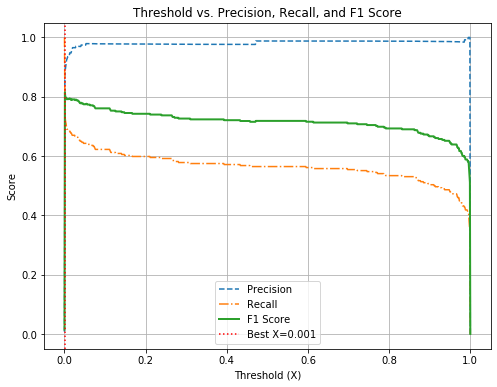

Best Threshold (X) for max F1: 0.001, F1 Score: 0.8147


In [376]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the range of threshold values
thresholds = np.linspace(0, 1, 1000)  # 100 values between 0 and 1

# Store precision, recall, and F1 scores for each threshold
precision_scores = []
recall_scores = []
f1_scores = []

# Compute metrics for each threshold
for X in thresholds:
    y_pred2 = (y_pred_proba >= X).astype(int)
    precision = precision_score(y_test, y_pred2)
    recall = recall_score(y_test, y_pred2)
    f1 = f1_score(y_test, y_pred2)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label="Precision", linestyle="--")
plt.plot(thresholds, recall_scores, label="Recall", linestyle="-.")
plt.plot(thresholds, f1_scores, label="F1 Score", linewidth=2)
plt.xlabel("Threshold (X)")
plt.ylabel("Score")
plt.title("Threshold vs. Precision, Recall, and F1 Score")
plt.legend()
plt.grid()

# Find the threshold that gives the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

plt.axvline(best_threshold, color="red", linestyle=":", label=f"Best X={best_threshold:.3f}")
plt.legend()

# Show the plot
plt.show()

# Print the best threshold and corresponding F1 score
print(f"Best Threshold (X) for max F1: {best_threshold:.3f}, F1 Score: {best_f1:.4f}")


## NN models

In [459]:
X_train.shape

(160691, 674)

In [460]:
# Define time steps (how many sequential columns make one sequence)
time_steps = 4  # Adjust this based on how much sequence dependency you want to capture

# Reshape X_train
num_samples = X_train_trimmed.shape[0]
num_features = X_train_trimmed.shape[1] // time_steps  # Assuming all features form a sequence

# Ensure data reshapes correctly
if X_train_trimmed.shape[1] % time_steps != 0:
    print("⚠️ Warning: Features do not perfectly divide into time steps!")

X_train_rnn = X_train_trimmed.values.reshape(num_samples, time_steps, num_features)
X_test_rnn = X_test_trimmed.values.reshape(X_test.shape[0], time_steps, num_features)

In [515]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build RNN Model
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, num_features)),  # First LSTM layer
    Dropout(0.2),
    LSTM(32, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output (0 or 1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [516]:
X_train_rnn = np.nan_to_num(X_train_rnn)  
X_test_rnn = np.nan_to_num(X_test_rnn)# Replace NaNs with 0
y_train = np.nan_to_num(y_train) 

In [517]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # or clipnorm=1.0
rnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [518]:
# Train the RNN model
rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_rnn, y_test))


Epoch 1/50
5022/5022 [==============================] - 24s 4ms/step - loss: 0.0316 - accuracy: 0.9927 - val_loss: 0.0252 - val_accuracy: 0.9927
Epoch 2/50
5022/5022 [==============================] - 22s 4ms/step - loss: 0.0265 - accuracy: 0.9927 - val_loss: 0.0248 - val_accuracy: 0.9927
Epoch 3/50
5022/5022 [==============================] - 22s 4ms/step - loss: 0.0254 - accuracy: 0.9927 - val_loss: 0.0238 - val_accuracy: 0.9927
Epoch 4/50
5022/5022 [==============================] - 22s 4ms/step - loss: 0.0242 - accuracy: 0.9927 - val_loss: 0.0230 - val_accuracy: 0.9928
Epoch 5/50
5022/5022 [==============================] - 21s 4ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0225 - val_accuracy: 0.9926
Epoch 6/50
5022/5022 [==============================] - 22s 4ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0228 - val_accuracy: 0.9931
Epoch 7/50
5022/5022 [==============================] - 22s 4ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0246 - val_ac

In [519]:
# Predict probabilities
y_pred_proba_rnn = rnn_model.predict(X_test_rnn)

In [482]:
y_pred_proba_rnn = np.ravel(y_pred_proba_rnn)
y_pred_proba = np.ravel(y_pred_proba)

In [520]:
# Convert probabilities to binary values (adjust threshold if needed)
y_pred = (y_pred_proba_rnn >= 0.3).astype(int)

In [521]:

# Evaluate Performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5784
Recall: 0.6020
F1 Score: 0.5900


## need to make precision and recall same to get high f1

In [66]:
y_pred_adj = (y_pred_proba >= 0.29).astype(int)

In [67]:
precision = precision_score(y_test, y_pred_adj)
recall = recall_score(y_test, y_pred_adj)
f1 = f1_score(y_test, y_pred_adj)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.809524
Recall: 0.636054
F1 Score: 0.7124


In [13]:
precision = precision_score(y_test, y_pred_adj)
recall = recall_score(y_test, y_pred_adj)
f1 = f1_score(y_test, y_pred_adj)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.760163
Recall: 0.636054
F1 Score: 0.6926


In [59]:
# Count occurrences of 0s and 1s
unique, counts = np.unique(y_pred_adj, return_counts=True)
print("\n🔹 Prediction Counts:")
print(dict(zip(unique, counts)))


🔹 Prediction Counts:
{0: 39914, 1: 259}


In [60]:
39914/259

154.1081081081081

## Run on testing dataset

In [417]:
test_df = pd.read_csv("Testing/merged_cleaned_test.csv")

In [418]:
test_df_ID = test_df["ID"]

In [419]:
test_df.shape

(25108, 672)

In [420]:
test_df = test_df.drop(columns=["ID"], errors="ignore")

In [421]:
test_df.columns = [lazy_pinyin(col)[0] for col in test_df.columns]

In [416]:
test_df.columns[]

Index(['wai_0', 'wai_1', 'wai_2', 'wai_3', 'wai_4', 'wai_5', 'wai_6', 'wai_7',
       'wai_8', 'wai_9',
       ...
       'shang_45', 'shang_46', 'shang_47', 'shang_48', 'shang_49', 'shang_50',
       'shang_51', 'shang_52', 'shang_53', 'shang_54'],
      dtype='object', length=671)

In [422]:
test_df.columns = [f"{col}_{i}" if test_df.columns.duplicated()[i] else col for i, col in enumerate(test_df.columns)]

In [415]:
#test_df.columns = test_df.columns.astype(str)
# Rename duplicate columns by adding a suffix (_1, _2, etc.)
#test_df.columns = pd.Series(test_df.columns).astype(str) + "_" + pd.Series(test_df.columns).groupby(test_df.columns).cumcount().astype(str)


In [423]:
test_df = test_df.fillna(test_df.mean())

In [424]:
# Calculate IQR for all numerical features
Q1 = test_df.quantile(0.25)
Q3 = test_df.quantile(0.75)
IQR = Q3 - Q1

# Define outliers: Any value outside 1.5 * IQR bounds
outlier_mask = (test_df < (Q1 - 1.5 * IQR)) | (test_df > (Q3 + 1.5 * IQR))

# Create an "outlier count" column (number of outlier features per row)
test_df["outlier_count"] = outlier_mask.sum(axis=1)

# Optional: Convert to binary flag (1 if any outlier, 0 if none)
test_df["is_outlier"] = (test_df["outlier_count"] > 0).astype(int)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
test_df["outlier_count_scaled"] = scaler.fit_transform(test_df[["outlier_count"]])

In [425]:
test_df.shape

(25108, 674)

In [426]:
X_test_trimmed.shape

(40173, 80)

In [ ]:
test_pred_proba = bigModel.predict_proba(test_df)[:, 1]

### Trimmed result

In [427]:
test_df_trimmed = test_df[top_features]

In [428]:
test_df_trimmed.shape

(25108, 80)

In [429]:
# Predict probabilities for class 1
test_pred_proba_trimmed = bigModel_trimmed.predict_proba(test_df_trimmed)[:, 1]

In [430]:
# Convert to binary predictions (0/1) using threshold 0.5
test_pred_trimmed = (test_pred_proba_trimmed >= 0.001).astype(int)

### RNN

In [489]:
test_df_trimmed_rnn = test_df_trimmed.values.reshape(test_df_trimmed.shape[0], time_steps, num_features)

In [490]:
test_pred_proba_rnn = rnn_model.predict(test_df_trimmed_rnn)

In [496]:
test_pred_proba_rnn = np.ravel(test_pred_proba_rnn)
test_pred_proba = np.ravel(test_pred_proba_trimmed*1000)
test_pred_proba_blend = (test_pred_proba_rnn + test_pred_proba) / 2

In [499]:
test_pred_blend = (test_pred_proba_blend >= 0.3).astype(int)

In [146]:
submission_df = pd.DataFrame({"ID": test_df_ID, "Predicted": test_pred})


In [431]:
submission_df_2 = pd.DataFrame({"ID": test_df_ID, "Predicted": test_pred_trimmed})


In [503]:
submission_df_3 = pd.DataFrame({"ID": test_df_ID, "Predicted": test_pred_blend})


In [504]:
merged_df = submission_df_2.merge(submission_df_3, on='ID', suffixes=('_old', '_new'))

# Find rows where Predicted changed
changed = merged_df[merged_df['Predicted_old'] != merged_df['Predicted_new']]

print(changed)

             ID  Predicted_old  Predicted_new
1644    PU-3394              0              1
3163     PU-395              0              1
3275    PU-4774              0              1
3919    PU-5418              0              1
4005    PU-5504              0              1
4756    PU-6255              0              1
7042    PU-8290              0              1
7250    PU-8498              0              1
8003    PU-9251              0              1
9042   PU-10039              0              1
9451   PU-10448              0              1
10411  PU-11408              0              1
10628  PU-11625              0              1
10726  PU-11723              0              1
11002  PU-11999              0              1
12443  PU-13189              0              1
12904  PU-13650              0              1
13374  PU-14120              0              1
14480  PU-14975              0              1
15181  PU-15676              0              1
16785  PU-17280              0    

In [501]:
# Count occurrences of 0s and 1s
unique, counts = np.unique(test_pred_blend, return_counts=True)
print("\n🔹 Prediction Counts:")
print(dict(zip(unique, counts)))


🔹 Prediction Counts:
{0: 24931, 1: 177}


In [502]:
24931/177

140.85310734463278

In [129]:
df['biao'].value_counts()

0    199394
1      1470
Name: biao, dtype: int64

In [130]:
199394/1470

135.6421768707483

In [80]:
# Count occurrences of 0s and 1s
unique, counts = np.unique(test_pred, return_counts=True)
print("\n🔹 Prediction Counts:")
print(dict(zip(unique, counts)))

,ID,Predicted
760,PU-25108,0


In [505]:
submission_df_3.to_csv("Submission//submission_0320_3.csv",index=False)